#### Data: Combined with added features , Shades and Radiation. <br>
Split: Train, Validate, Test

# 1. Import and Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
# To: install catboost
# !pip3 install catboost

# explain
from sklearn.tree import export_graphviz
import lime
import lime.lime_tabular

from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# import shap

In [3]:
Bldg = pd.read_csv("../Data/microclimate_model/Combined/all_buildings_9pm.csv")
Bldg = Bldg.drop(columns = ['Unnamed: 0','CHWTON', 'Minute'])

In [4]:
Tree_X = pd.read_csv("../Data/microclimate_model/Combined/June_9_NoTrees.csv")
Tree_X = Tree_X.drop(columns = ['Unnamed: 0','CHWTON','CHWTON/SQFT' ])


# 2. EDA

## 2.1 Compare Temperature

In [5]:
J_9 = Bldg[(Bldg['Month'] == 6) & (Bldg['Day'] == 9)]

temperature = pd.DataFrame()
temperature['bldgname'] = J_9['bldgname']
temperature['Base'] = J_9['Air Temp']
temperature = temperature.reset_index()
temperature['Tree'] = Tree_X['Air Temp']

temperature.drop(columns = ['index'], inplace = True)

temperature


,bldgname,Base,Tree
0,Noble Library,29.578951,29.721866
1,Noble Library,29.068746,29.638193
2,Noble Library,28.741506,28.571992
3,Noble Library,28.550811,28.432941
4,Noble Library,28.346988,28.322541
...,...,...,...
635,Biodesign B,38.580270,38.609851
636,Biodesign B,38.333556,38.306810
637,Biodesign B,38.067908,38.026686
638,Biodesign B,37.871024,37.793202


In [6]:
temperature[temperature['bldgname'] == 'Noble Library']['Tree']

0     29.721866
1     29.638193
2     28.571992
3     28.432941
4     28.322541
        ...    
59    38.644326
60    38.377710
61    38.112677
62    37.882290
63    37.662191
Name: Tree, Length: 64, dtype: float64

64
64
64
64
64
64
64
64
64


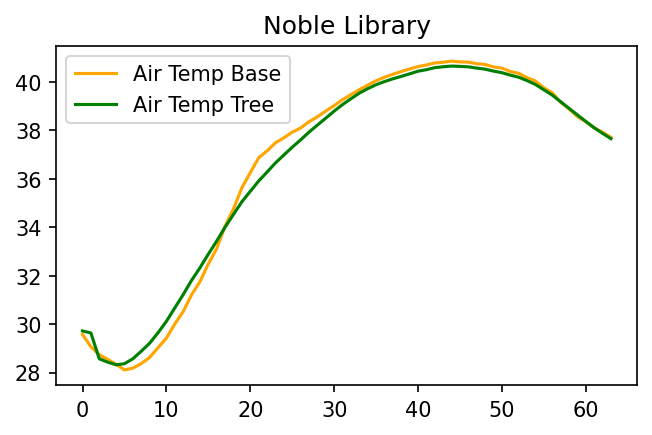

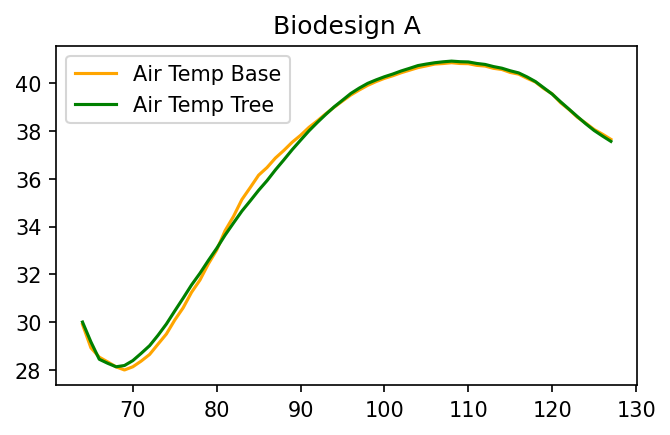

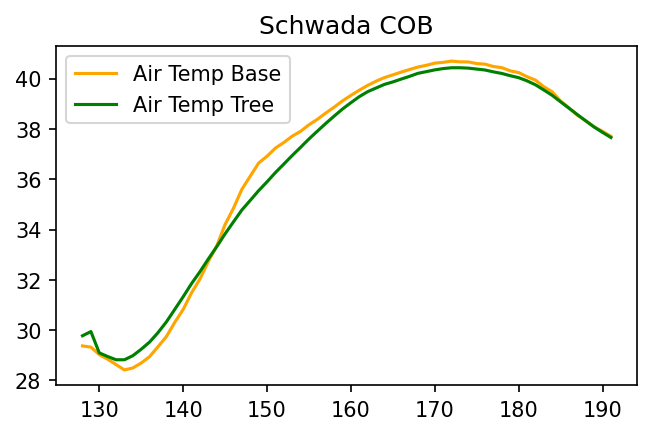

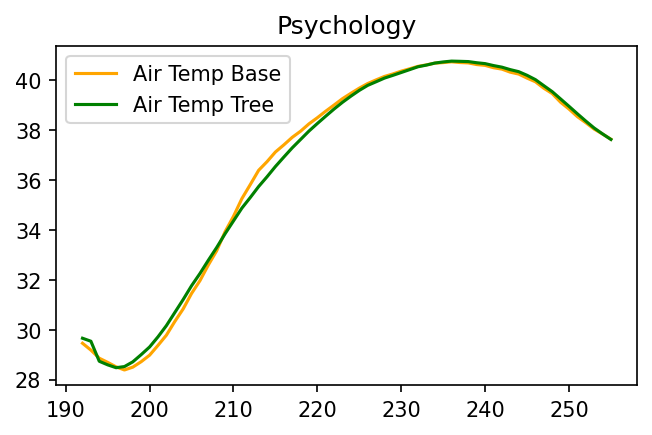

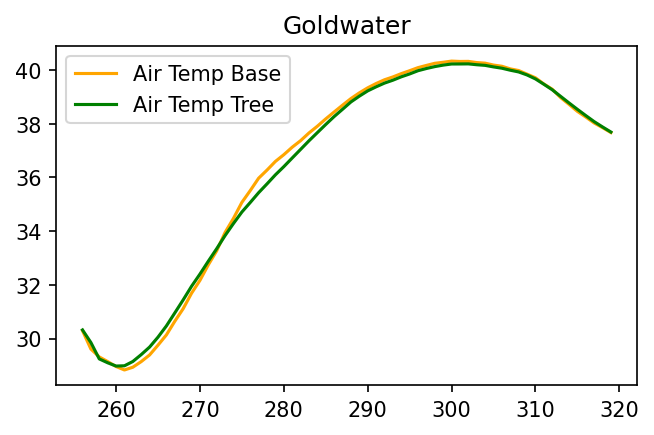

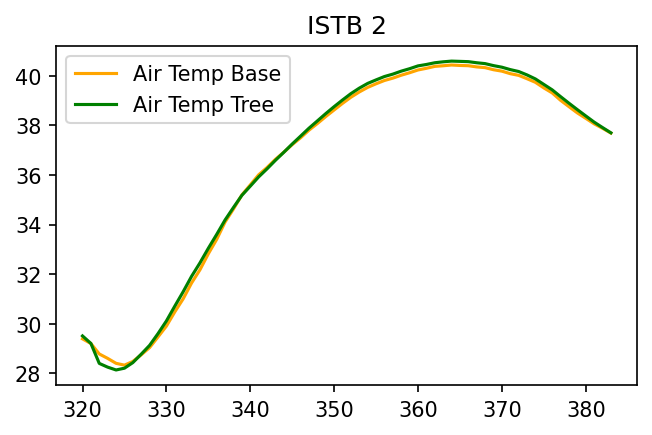

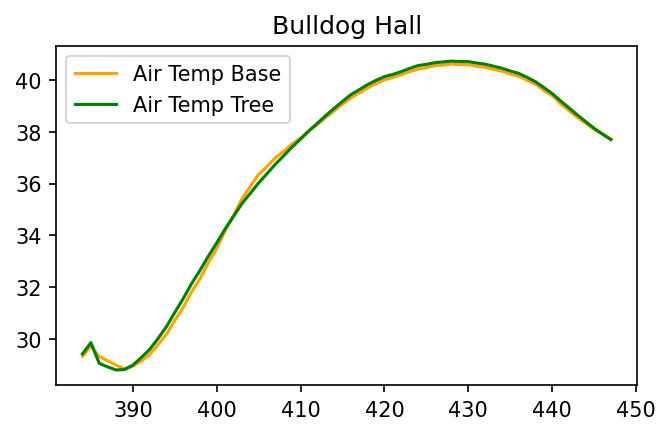

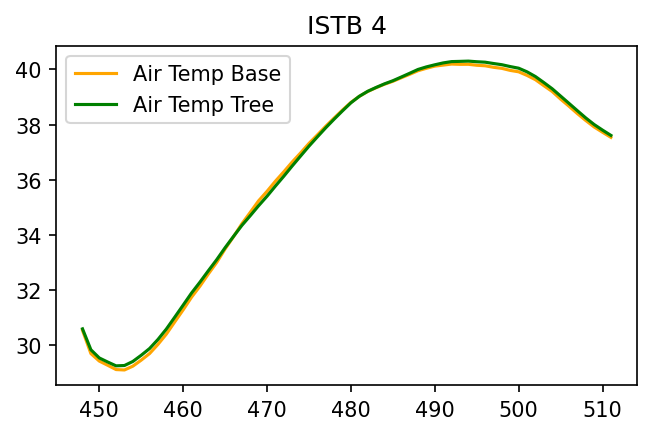

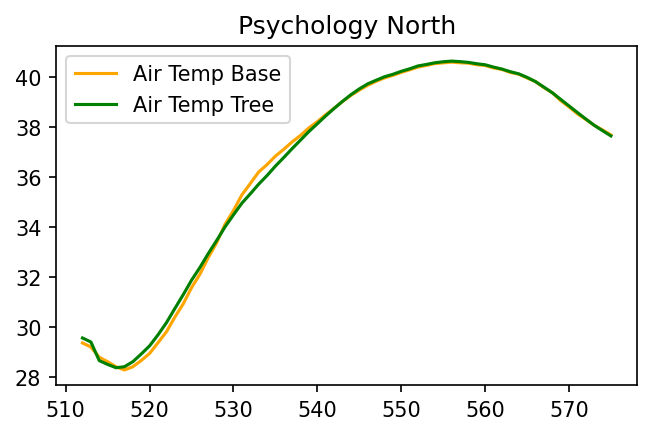

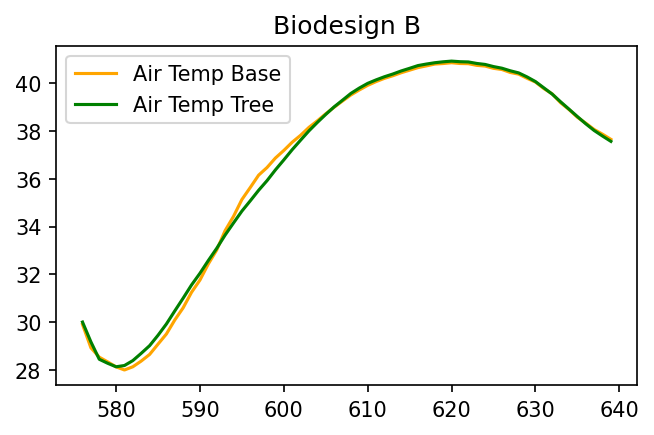

In [7]:
# # 1. get label for plot
BldgName = list(Bldg.bldgname.unique())
BldgnameTest = BldgName 
BldgnameTest.pop(1) # remove the second building (data doesnt exists)


# 2. get position for plots
# print the number of elements per building
for i in range(len(BldgnameTest)-1):
    print((temperature.bldgname == BldgName[i]).sum())
    
# # create array accordingly
position = np.linspace(0, 640, num=11).tolist()

# remove last index
position.pop()

for i in range(len(BldgnameTest)):
    # from matplotlib.pyplot import figure
    figure(figsize=(5, 3), dpi=150)
    # plt.xticks( position, BldgnameTest )
    plt.plot(temperature[temperature['bldgname'] == BldgnameTest[i]]['Base'], label = 'Air Temp Base', color="orange")
    plt.plot(temperature[temperature['bldgname'] == BldgnameTest[i]]['Tree'], label = 'Air Temp Tree', color="green")
    plt.legend()
    plt.title(BldgnameTest[i])

## 2.2 Boxplots

In [ ]:
# # 1. Create List of building names so we can extract the name easily 
# BldgName = list(Bldg.bldgname.unique())

# # 2. Create list of building df to do time series plot of CHWTON
# BldgList = []

# for i in range(len(BldgName)):
#     bldg_single = Bldg[Bldg['bldgname'] == BldgName[i]]
#     bldg_single = bldg_single[['bldgname', 'Date_Time','CHWTON/SQFT','Hour']]
#     bldg_single[BldgName[i]] = bldg_single['CHWTON/SQFT']
#     bldg_single = bldg_single.drop(columns = ['bldgname'])
#     BldgList.append(bldg_single)
    

# #3. Create CHWTON boxplots for all buildings #
# def createBoxPlot(df, columnName, BldgName):
#     row_size = 6
#     column_size = 2
#     fig, ax = plt.subplots(row_size, column_size, figsize = (15,40))

#     i = 0
#     # 1. loop through the 11 buildings
#     while i < (len(BldgName)):
#         # 2. Create row (6)
#         for row in range(row_size):
#             #4. Create column 2
#             for col in range(column_size):
#                 if i < (len(BldgName)):
                    
#                     # create boxplot of this df
#                     df[i].boxplot(by='Hour',
#                                     column=[columnName],
#                                     grid = False,
#                                     figsize = (4,4),
#                                     ax = ax[row,col] )
#                     ax[row,col].title.set_text(BldgName[i])
#                     i += 1

#     fig.suptitle(columnName + ' Boxplot by Hour')
#     plt.show()
    
# createBoxPlot(BldgList, 'CHWTON/SQFT', BldgName)

## 2.3 Feature engineering Temp and Humidity

In [8]:
# Get Air Temp X Abs Hum
Bldg = Bldg.drop(columns = ['Rel Hum'])

Bldg['AirTempXAbsHum'] = Bldg['Air Temp'] * Bldg['Abs Hum']
Bldg['AirTempSq'] = Bldg['Air Temp'] * Bldg['Air Temp']
Bldg['AbsHumSq'] = Bldg['Abs Hum'] * Bldg['Abs Hum']
Bldg = Bldg.drop(columns = ['Air Temp', 'Abs Hum'])

# Remove August and September data
Bldg = Bldg[~((Bldg['Month'] == 8) | (Bldg['Month'] == 9))]


# Get Air Temp X Abs Hum
Tree_X = Tree_X.drop(columns = ['Rel Hum'])

Tree_X['AirTempXAbsHum'] = Tree_X['Air Temp'] * Tree_X['Abs Hum']
Tree_X['AirTempSq'] = Tree_X['Air Temp'] * Tree_X['Air Temp']
Tree_X['AbsHumSq'] = Tree_X['Abs Hum'] * Tree_X['Abs Hum']
Tree_X = Tree_X.drop(columns = ['Air Temp', 'Abs Hum'])

# Remove August and September data
Tree_X = Tree_X[~((Tree_X['Month'] == 8) | (Tree_X['Month'] == 9))]

In [9]:
Tree_X

,bldgname,Date_Time,Month,Day,Hour,Minute,DSW Top,DSW North,DSW East,DSW South,DSW West,Shade North,Shade East,Shade South,Shade West,KW,HTmmBTU,AirTempXAbsHum,AirTempSq,AbsHumSq
0,Noble Library,2018-06-09 05:00:00,6,9,5,0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,95.45,-0.01,111.456416,883.389332,14.062353
1,Noble Library,2018-06-09 05:15:00,6,9,5,15,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,90.39,-0.01,121.354585,878.422507,16.765207
2,Noble Library,2018-06-09 05:30:00,6,9,5,30,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,94.59,-0.01,125.919348,816.358749,19.422444
3,Noble Library,2018-06-09 05:45:00,6,9,5,45,1.276640,2.912001,10.742129,0.0,0.0,0.801075,0.55061,1.0,1.0,88.48,-0.01,125.378689,808.432134,19.444818
4,Noble Library,2018-06-09 06:00:00,6,9,6,0,41.178288,87.093112,220.015809,0.0,0.0,0.548387,0.37539,1.0,1.0,89.92,-0.01,125.056384,802.166344,19.496080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Biodesign B,2018-06-09 19:45:00,6,9,19,45,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,513.78,0.60,115.466999,1490.720624,8.943747
636,Biodesign B,2018-06-09 20:00:00,6,9,20,0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,510.73,0.59,113.992710,1467.411654,8.855278
637,Biodesign B,2018-06-09 20:15:00,6,9,20,15,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,508.51,0.65,113.358174,1446.028843,8.886459
638,Biodesign B,2018-06-09 20:30:00,6,9,20,30,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.00000,1.0,1.0,492.89,0.60,113.808420,1428.326096,9.068207


## 2.4 Time Series Plot

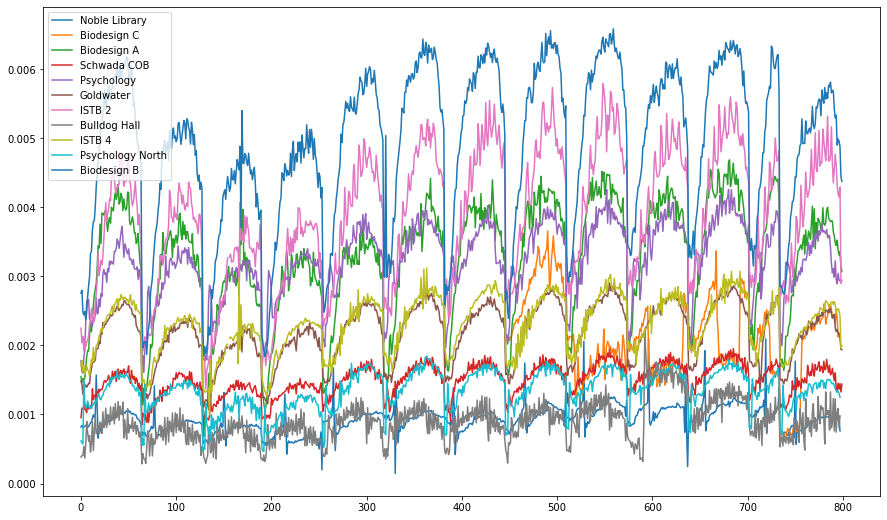

In [10]:
# 1. Create List of building names so we can extract the name easily 
BldgName = list(Bldg.bldgname.unique())

# 2. Create list of building df to do time series plot of CHWTON
BldgList = []

for i in range(len(BldgName)):
    bldg_single = Bldg[Bldg['bldgname'] == BldgName[i]]
    bldg_single = bldg_single[['bldgname', 'Date_Time','CHWTON/SQFT']]
    bldg_single[BldgName[i]] = bldg_single['CHWTON/SQFT']
    bldg_single = bldg_single.drop(columns = ['bldgname', 'CHWTON/SQFT'])
    BldgList.append(bldg_single)
    
Bldg = Bldg.drop(columns = ['Date_Time'])

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date_Time'],
                                            how='outer'), BldgList)


# Print CHWTON/SQFT for all buildings and all timestamps in data
ax = df_merged['Noble Library'].plot(figsize = (15,9))
legendlabels = []
legendlabels.append('Noble Library')

for i in range(2, 12):
    bldgName = df_merged.columns[i]
    df_merged[bldgName].plot(ax=ax)
    legendlabels.append(df_merged.columns[i])
    
ax.legend(labels = legendlabels)

## 2.5 Corr. Matrix


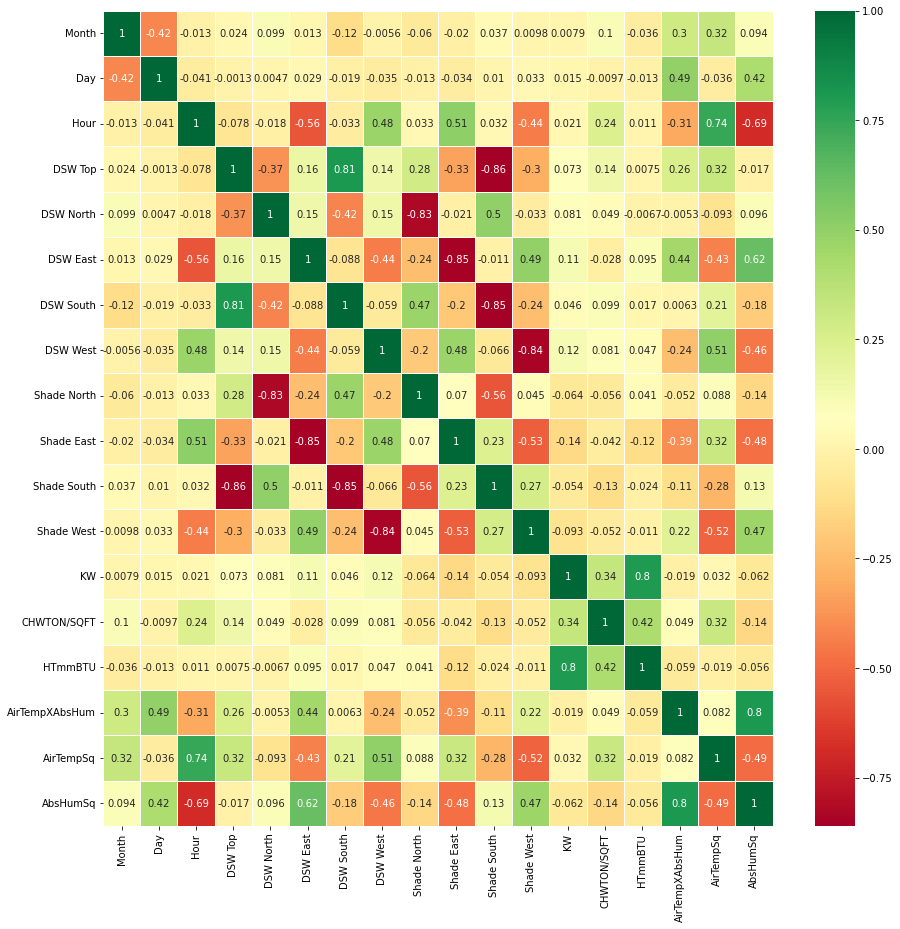

In [11]:
corrMatrix = Bldg.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, cmap='RdYlGn', annot = True, linewidths = 1)
plt.show()

# 3. One Hot Encoding

In [ ]:
# Integer Encode
Bldg = pd.get_dummies(Bldg, drop_first = True)
Bldg.columns

# 4. Modelling set up

## 4.1 Pick desired date for Test

Month available:<br>
May: 10, 16, 23, 28<br>
June: 7, 8, 9, 20, 21, 25, 26, 27<br>
July: 1<br>

Not Usable:<br>
August: 1, 3, 27<br>
September: 11, 29<br>

June 9 tree<br>



In [ ]:
####---- DO NOT PICK TREE 00 00 for tree scenario----- ###
# Just pick June 9th so we can compare it with tree
# We will just do prediction on tree scenario

# 1. Get user to pick the day
day = (input("Pick month and day <mm dd>: "))
m,d = day.split(" ")
m = int(m)
d= int(d)

# 2. If its tree:
if (m == 0) & (d == 0):
    print("you picked heat-mitigation scenario")
else:
    # if not tree and not available:
    while (len(Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]) == 0):
        day = (input("Date unavailable, pick month and day <mm dd>: "))
        m,d = day.split(" ")
        m = int(m)
        d = int(d)
    

print("You picked month: ", m, ", day: ",d)

In [ ]:
# Check this test data
# Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]

In [ ]:
# Create test data frame
if(m == 0) & (d == 0):
    Test_df = Tree_X
else:
    Test_df = Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]
    Test_df.reset_index(drop = True, inplace = True)
    Test_df

    # Remove Test From Bldg df 
Bldg = Bldg[~((Bldg['Month'] == m) & (Bldg['Day'] == d))]


# Check if the day is still there
Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]

In [ ]:
Test_df

## 4.3 Cyclic Time

In [ ]:
# 1. function to encode df columns into sine and cosine
def encode(df, col, max_val):
    df[col.replace('_num', '') + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col.replace('_num', '') + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(columns = [col], inplace = True)
    return df

# 2. create a list of df for datas with cyclical time features
Bldg_cyclic = []

Bldg_enc = Bldg.copy(deep = True)
Bldg_enc = encode(Bldg_enc, 'Minute', 60.0)
Bldg_enc = encode(Bldg_enc, 'Hour', 23.0)
Bldg_enc = encode(Bldg_enc, 'Day', 30.0)
Bldg_enc = encode(Bldg_enc, 'Month', 12.0)

# 
Bldg_cyclic = Bldg_enc
print(Bldg_cyclic.columns)


In [ ]:
# 3. create a list of df for Test dates with cyclical time features
Test_cyclic = []

Test_enc = Test_df.copy(deep = True)
Test_enc = encode(Test_enc, 'Minute', 60.0)
Test_enc = encode(Test_enc, 'Hour', 23.0)
Test_enc = encode(Test_enc, 'Day', 30.0)
Test_enc = encode(Test_enc, 'Month', 12.0)

Test_cyclic = Test_enc 
print(Test_cyclic.columns)
Test_cyclic

## 4.4 Scoring function

In [ ]:
scores_df = pd.DataFrame()
# function to train a model and get its scores
def trainAndGetScore(pModel, pModelName, pTuningType, pDf_all_bldg, pDf_scores, pTest_df):
    # 1. drop na values if in dataframe
    if (pDf_all_bldg.isnull().values.any() == True):
        pDf_all_bldg = pDf_all_bldg.dropna()
            
    # 2. split data into X and y
    X = pDf_all_bldg.drop(columns=['CHWTON/SQFT'])
    y = pDf_all_bldg['CHWTON/SQFT']  
    
    X_test = pTest_df
    X_test = pTest_df.drop(columns=['CHWTON/SQFT'])
    y_test = pTest_df['CHWTON/SQFT']  
    
    # 3. Train-Validate Split
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
    # 4. Fit model that already has parameters
    pModel.fit(X_train, y_train)
    
    
    # 5. Get best params if it's a random or grid search
    if("random" in pTuningType) or ("grid" in pTuningType):
        print(pModel.best_estimator_.get_params())
        
    # 6. Get score
    scoreTrain = pModel.score(X_train, y_train)
    scoreValidate = pModel.score(X_validate, y_validate)
    scoreTest = pModel.score(X_test, y_test)
    
    print(X_test.columns)
    # 7. Get prediction on test set
    y_pred = pModel.predict(X_test)
    pred_df = pd.DataFrame({'Bldgname': Tree_X.bldgname ,'Act CHWTON/SQFT':y_test, 'Pred CHWTON/SQFT':y_pred})
    pred_df = pred_df.sort_index()
    print(pred_df)
    
    
    # 8. Save Score
    
    # 8.1 Get index
    # a) if this is the first entry
    if (len(pDf_scores) == 0):
        i = 0
    else:
        modelNameExist = False
        # b) if the model name we have is already existing df's row , use that index
        for df_index in range(len(pDf_scores)):
            if pDf_scores.loc[df_index, 'modelName'] == pModelName:
                i = df_index
                modelNameExist = True
        # c) if this a a new model name:
        if modelNameExist == False:
                # new model name add to new row
                i = len(pDf_scores)
            
    # 8.2 Add scores to df
    pDf_scores.loc[i,'TestDate'] = str(m) + " " + str(d)
    pDf_scores.loc[i,'modelName'] = pModelName
    pDf_scores.loc[i,pTuningType + "Train"] = scoreTrain
    pDf_scores.loc[i,pTuningType + "Validate"] = scoreValidate
    pDf_scores.loc[i,pTuningType + "Test"] = scoreTest
    
    return pred_df
    

# 5. Model 1: Random Forest


## 5.1 Predict Base - No Tuning

In [ ]:
RF_base = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True)
# 1. Base RF on base data
predBase = trainAndGetScore(RF_base, "RF", "base", Bldg, scores_df, Test_df)

# 2. Base RF on cyclical time features
# predCyclic = trainAndGetScore(RF_base, "RF_cyclic", "base", Bldg_cyclic, scores_df, Test_cyclic)



In [ ]:
scores_df

In [ ]:
# Feature importance
feature_list = list(Bldg.drop(columns = ['CHWTON/SQFT']).columns)
feature_imp = pd.Series(RF_base.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")

### 5.1.1 Predict Tree June 9th - No Tuning

In [ ]:
# Tidy up column for our Tree_X dataframe
# drop unused column
Tree_XCopy = Tree_X.drop(columns = ['Date_Time'], inplace = True)

# Integer Encode
Tree_XCopy  = pd.get_dummies(Tree_X, drop_first = True)
Tree_XCopy .columns

# add bldgname_Biodesign C column assign 0
Tree_XCopy ['bldgname_Biodesign C'] = 0

# Rearrange Column
Tree_XCopy  = Tree_XCopy [['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North', 'Shade East', 'Shade South',
       'Shade West', 'KW', 'HTmmBTU', 'AirTempXAbsHum', 'AirTempSq',
       'AbsHumSq', 'bldgname_Biodesign B', 'bldgname_Biodesign C',
       'bldgname_Bulldog Hall', 'bldgname_Goldwater', 'bldgname_ISTB 2',
       'bldgname_ISTB 4', 'bldgname_Noble Library', 'bldgname_Psychology',
       'bldgname_Psychology North', 'bldgname_Schwada COB']]

In [ ]:
tree_pred = RF_base.predict(Tree_XCopy)

In [ ]:
predBase['Tree pred CHWTON/SQFT'] = tree_pred

### 5.1.2 Plot Base June 9th Prediction

In [ ]:
predBase

In [ ]:

for i in range(len(BldgnameTest)):
    figure(figsize=(10, 7), dpi=100)
    # plt.xticks(position, BldgnameTest )
               
    single_bld = predBase[predBase['Bldgname'] == BldgnameTest[i]]   
    plt.ylabel('CHWTON/SQFT')
    plt.plot(single_bld['Act CHWTON/SQFT'], label = 'J9 Actual')
    plt.plot(single_bld['Pred CHWTON/SQFT'], label = 'J9 Base Prediction')
    plt.plot(single_bld['Tree pred CHWTON/SQFT'], label = 'J9 Tree Prediction')
    plt.legend()
    plt.title(BldgnameTest[i])           

               
               

## 5.2 Random Search Tuning

https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

1. n_estimators:  In general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set. <br>
2. max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.<br>
3. max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result. <br>
4. min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each. <br>


In [ ]:
# Define parameters for RF

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

In [ ]:
# 1. Set parameters on random_RF
RF_random = RandomizedSearchCV(estimator = RF_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_random, "RF", "random", Bldg, scores_df, Test_df)

# 3. Train on data with cyclical time features
# trainAndGetScore(RF_random, "RF_cyclic", "random", Bldg_cyclic, scores_df, Test_cyclic)

scores_df

In [ ]:
print(RF_random.best_estimator_.get_params())

In [ ]:
# Get oob score for best random model

# 1. grab the param from best random search result
RF_best_limit_depth = RandomForestRegressor(n_estimators = 150,
                                       random_state = 42,
                                       max_depth = 7,
                                       oob_score = True,
                                       min_samples_split= 2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf = 0.0)

RF_best_limit_depth
# 2. split data into X and y
X = Bldg.drop(columns=['CHWTON/SQFT'])
y = Bldg['CHWTON/SQFT']  
    
X_test = Test_df.drop(columns=['CHWTON/SQFT'])
y_test = Test_df['CHWTON/SQFT']  
    
# 3. Train-Test Split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
# 4. Fit model that already has parameters
RF_best_limit_depth.fit(X_train, y_train)
RF_best_limit_depth.oob_score_

## 5.3 RF Explain Tree

In [ ]:
# Get X for Explaining
BldgX = Bldg.drop(columns = 'CHWTON/SQFT')
Bldg_cyclicX = Bldg_cyclic.drop(columns = 'CHWTON/SQFT')

In [ ]:
RF_best_limit_depth = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True, max_depth = 7)
# 1. Base RF on base data
trainAndGetScore(RF_best_limit_depth, "RF_limit_depth", "base", Bldg, scores_df, Test_df)

In [ ]:
# 3. Extract single tree
estimator = RF_best_limit_depth.estimators_[3]

from sklearn.tree import export_graphviz

# 4. Export tree as dot file
export_graphviz(estimator,
                out_file='tree.dot', 
                feature_names = BldgX.columns,
                rounded = True,
                proportion = False, 
                precision = 7,
                filled = True)

# # 5. Convert the tree to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # 6. Display png image of this one tree in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
from dtreeviz.trees import dtreeviz 

In [ ]:
viz = dtreeviz(estimator, X_train, y_train, feature_names=X_train.columns, target_name='CHWTON/SQFT')
viz


## 5.4 RF Lime

https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b

### 5.4.1 Create Explainer

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names = BldgX,
                                                   class_names = 'CHWTON/SQFT',
                                                   verbose = True,
                                                   mode = 'regression')

In [ ]:

i = 10
exp = explainer.explain_instance(X_test.values[i], RF_best_limit_depth.predict)



In [ ]:
exp.show_in_notebook()

In [ ]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()

## 5.5 RF Grid Search Tuning

In [ ]:
param_grid = {'n_estimators': [150, 170],
               'max_features': ["sqrt"],
               'max_depth': [50,60,70],
               'min_samples_split': [2, 3],
               'min_samples_leaf': [ 1, 2],
               'bootstrap': bootstrap}

In [ ]:
# 1. Set parameters on random_RF
RF_grid = GridSearchCV(estimator = RF_base,
                       param_grid = param_grid,
                       cv = 5,
                       scoring ='r2',
                       n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_grid, "RF", "grid", Bldg, scores_df, Test_df)

# 3. Train on data with cyclical time features
# trainAndGetScore(RF_grid, "RF_cyclic", "grid", Bldg_cyclic, scores_df, Test_cyclic)
scores_df

# 6. Model 2: XGBoost

## 6.1 No Tuning

In [ ]:
# 1. create base model
XGB_base = XGBRegressor(n_estimators = 100, random_state = 42)

# 2. Base XGB on base data
trainAndGetScore(XGB_base, "XGB", "base", Bldg, scores_df, Test_df)

# 3. Base XGB on cyclica time features
# trainAndGetScore(XGB_base, "XGB_cyclic", "base", Bldg_cyclic, scores_df)
scores_df

## 6.2 Random Search Tuning

In [ ]:
# 1. Define grid
params = {
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[4,5,8], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

# 2. Set up model with grid
n_iter_search = 20
XGB_random = RandomizedSearchCV(XGB_base,
                                param_distributions = params,
                                n_iter = n_iter_search,
                                cv = 5,
                                verbose = 2,
                                random_state = 42,
                                scoring ='r2',
                                n_jobs = -1)

# 2. Train on base data
trainAndGetScore(XGB_random, "XGB", "random", Bldg, scores_df,Test_df)

# 3. Train on data with cyclical time features
# trainAndGetScore(XGB_random, "XGB_random_cyclic", Bldg_cyclic, scores_df, Test_cyclic)
scores_df

# 7. Model 3: LightGBM

## 7.1 No Tuning

In [ ]:
LGBM_base = lgb.LGBMRegressor(random_state = 42)

# 2. Base LGBM on base data
trainAndGetScore(LGBM_base, "LGBM" , "base", Bldg, scores_df, Test_df)

# 3. Base LGBM on cyclica time features
# trainAndGetScore(LGBM_base, "LGBM_cylic", Bldg_cyclic, scores_df)
scores_df

## 7.2 Random Search Tuning

In [ ]:
# 1. Define grid
random_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

# 2. Set up model with grid
LGBM_random = RandomizedSearchCV(estimator = LGBM_base,
                                 param_distributions = random_grid, 
                                 n_iter = 100, cv = 2,
                                 scoring='r2',
                                 verbose= 2,
                                 random_state= 42,
                                 n_jobs = -1)


In [ ]:
# 3. Base LGBM on base data
# trainAndGetScore(LGBM_random, "LGBM_random", Bldg, scores_df)
trainAndGetScore(LGBM_base, "LGBM" , "random", Bldg, scores_df, Test_df)

# 4. Base LGBM on cyclica time features
# trainAndGetScore(LGBM_random, "LGBM_random_cyclic", Bldg_cyclic, scores_df)
scores_df

In [ ]:
print("ONE HOT ENCODING SCORE:")
scores_df

# 8. Model 4: Catboost

## 8.1 Prepare datas using label encoder

In [ ]:
Bldg_df_cat = pd.DataFrame()
for i in range(len(Bldg)):
    Bldg_df_cat = Bldg_df_cat.append(Bldg[i])
    
Bldg_df_cat.reset_index(drop = True , inplace = True)
Bldg_df_cat.drop(columns=['Date', 'Time', 'Date_Time'],inplace = True)

# # create a list of df for buildings with cyclical time features
# Bldg_cyclic_cat = []

# Bldg_enc = Bldg_df_cat.copy(deep = True)
# Bldg_enc = encode(Bldg_enc, 'Minute_num', 60.0)
# Bldg_enc = encode(Bldg_enc, 'Hour_num', 23.0)
# Bldg_enc = encode(Bldg_enc, 'Day_num', 30.0)
# Bldg_enc = encode(Bldg_enc, 'Month_num', 12.0)
# Bldg_cyclic_cat = Bldg_enc
    
# # Plot cyclical features sample
# fig, ax = plt.subplots(2,2, figsize = (8,7))
# Bldg_cyclic_cat.plot.scatter('Minute_sin', 'Minute_cos', ax = ax[0,0]).set_aspect('equal')
# Bldg_cyclic_cat.plot.scatter('Hour_sin', 'Hour_cos', ax = ax[0,1]).set_aspect('equal')
# Bldg_cyclic_cat.plot.scatter('Day_sin', 'Day_cos', ax = ax[1,0]).set_aspect('equal')
# Bldg_cyclic_cat.plot.scatter('Month_sin', 'Month_cos', ax = ax[1,1]).set_aspect('equal')


In [ ]:
# Bldg_cyclic_cat

In [ ]:
label_encoder = LabelEncoder()

# Assigning numerical values and storing in another column
Bldg_df_cat['bldgname'] = label_encoder.fit_transform(Bldg_df_cat['bldgname'])
Bldg_df_cat

In [ ]:
Bldg_df_cat.bldgname.unique()

In [ ]:
# 1. split data into X and y
X = Bldg_df_cat.drop(columns=['CHWTON', 'CHWTON/SQFT'])
y = Bldg_df_cat['CHWTON/SQFT']   

# 2. Train-Test Split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
X_test = test_df.drop(columns=['CHWTON', 'CHWTON/SQFT'])
y_test = test_df['CHWTON/SQFT']

## 8.2 Catboost Random Search

In [ ]:
# 1. hyperparameter grid
cb_grid = {'iterations': [50, 100, 150, 200, 250],
            'learning_rate': [0.03, 0.1],
            'depth': [2, 4, 8, 10, 12],
            'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7]}

# 2. instantiate RandomSearchCv object
CB_random_obj = RandomizedSearchCV(estimator = catboost,
                               param_distributions = cb_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)


# 3. Fit the model
CB_random_obj.fit(X_train,y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(CB_random_obj.best_estimator_.get_params())
pprint(CB_random_obj.best_score_)

# 5. get the best model
CB_random = CB_random_obj.best_estimator_

# 6. get validation , test score 
scoreTrain = CB_random.score(X_train, y_train)
scoreValidate = CB_random.score(X_validate, y_validate)
scoreTest = CB_random.score(X_test, y_yest)

  

In [ ]:
print(scoreTrain, scoreValidate, scoreTest)

## 8.3 Catboost Grid Search

In [ ]:
# 3. initialize model and grid
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'depth': [8, 10,12],
        'iterations': [230,250,270],
        'learning_rate': [0.08, 0.1, 0.15],
        'l2_leaf_reg': [0.8, 1, 2]}


# 4. search parameter
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit = True,
                           verbose = True,
                           train_size = 0.8 )


# 4. get best params
best_params = result['params']

# 5. fit model with best params
CB_grid = cb.CatBoostRegressor(depth = best_params['depth'],
                               iterations = best_params['iterations'],
                               learning_rate= best_params['learning_rate'],
                               l2_leaf_reg = best_params['l2_leaf_reg'])
CB_grid.fit(train_dataset)

# 6. get score 
score = CB_grid.score(X_test, y_test)
scores_df['CB_grid']=score
print(score)


In [ ]:
scores_df